<a href="https://colab.research.google.com/github/gatesz33/asian_recipe_classifier_ds4002/blob/main/ingredients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import json
import pandas as pd

# --- Target country cuisines ---
TARGET_CUISINES = {
    "chinese",
    "thai",
    "indian",
    "malaysian",
    "japanese",
    "philipines",
    "vietnamese",
    "indonesian"
}

# --- Parse recipe JSON-LD (title + ingredients + instructions) ---
def parse_recipe_jsonld(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "lxml")

    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)

            if isinstance(data, list):
                for entry in data:
                    if entry.get("@type") == "Recipe":
                        return {
                            "title": entry.get("name"),
                            "url": url,
                            "ingredients": entry.get("recipeIngredient", []),
                            "instructions": entry.get("recipeInstructions", [])
                        }
            elif isinstance(data, dict) and data.get("@type") == "Recipe":
                return {
                    "title": data.get("name"),
                    "url": url,
                    "ingredients": data.get("recipeIngredient", []),
                            "instructions": data.get("recipeInstructions", [])
                }
        except Exception:
            continue
    return None

# --- Get recipe links from category feed ---
def get_recipe_links_feed(feed_url, limit=20): # Use the 'limit' parameter
    resp = requests.get(feed_url)
    if resp.status_code != 200:
        return []
    root = ET.fromstring(resp.content)

    links = []
    # Use the 'limit' parameter in the slice
    for item in root.findall("./channel/item")[:limit]:
        link_elem = item.find("link")
        if link_elem is not None and link_elem.text:
            links.append(link_elem.text.strip())
    return links

# --- Get all category feed URLs from sitemap (with namespace fix) ---
def get_all_category_feeds():
    sitemap_url = "https://tasteasianfood.com/category-sitemap.xml"
    resp = requests.get(sitemap_url)
    resp.raise_for_status()
    root = ET.fromstring(resp.content)

    ns = {"sm": "http://www.sitemaps.org/schemas/sitemap/0.9"}
    feeds = {}
    for url_elem in root.findall(".//sm:loc", ns):
        cat_url = url_elem.text.strip()
        if "/category/" in cat_url:
            cat_name = cat_url.split("/")[-2].lower()   # normalize name
            feeds[cat_name] = cat_url + "feed/"
    return feeds

# --- Scrape only target country categories ---
def scrape_all(limit_per_cat=20):
    categories = get_all_category_feeds()
    categories = {name: feed for name, feed in categories.items() if name in TARGET_CUISINES}

    all_recipes = {}
    for name, feed_url in categories.items():
        print(f"Scraping {name}...")
        links = get_recipe_links_feed(feed_url, limit=limit_per_cat) # Pass limit_per_cat
        recipes = []
        for link in links:
            recipe = parse_recipe_jsonld(link)
            if recipe:
                recipes.append(recipe)
        all_recipes[name] = recipes
    return all_recipes

# --- Run ---
all_recipes = scrape_all(limit_per_cat=30)

# Save JSON (by country → by recipe → ingredients)
with open("asian_recipes_by_country.json", "w", encoding="utf-8") as f:
    json.dump(all_recipes, f, ensure_ascii=False, indent=2)

# Save CSV (flattened: one row per ingredient per recipe)
rows = []
for country, recipes in all_recipes.items():
    for r in recipes:
        for ing in r["ingredients"]:
            rows.append({
                "country": country,
                "recipe_title": r["title"],
                "recipe_url": r["url"],
                "ingredient": ing,
                "instructions": r["instructions"]
            })

df = pd.DataFrame(rows)
df.to_csv("asian_recipes_by_country.csv", index=False)

print("✅ Done! Saved to asian_recipes_by_country.json and asian_recipes_by_country.csv")

Scraping chinese...
Scraping indian...
Scraping indonesian...
Scraping japanese...
Scraping malaysian...
Scraping philipines...
Scraping thai...
Scraping vietnamese...
✅ Done! Saved to asian_recipes_by_country.json and asian_recipes_by_country.csv


In [3]:
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import json
import pandas as pd
import re

# --- Target country cuisines ---
TARGET_CUISINES = {
    "chinese",
    "thai",
    "indian",
    "malaysian",
    "japanese",
    "philipines",
    "vietnamese",
    "indonesian"
}

# --- Parse recipe JSON-LD (title + ingredients + instructions) ---
def parse_recipe_jsonld(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "lxml")

    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)

            if isinstance(data, list):
                for entry in data:
                    if entry.get("@type") == "Recipe":
                        return {
                            "title": entry.get("name"),
                            "url": url,
                            "ingredients": entry.get("recipeIngredient", []),
                            "instructions": entry.get("recipeInstructions", [])
                        }
            elif isinstance(data, dict) and data.get("@type") == "Recipe":
                return {
                    "title": data.get("name"),
                    "url": url,
                    "ingredients": data.get("recipeIngredient", []),
                            "instructions": data.get("recipeInstructions", [])
                }
        except Exception:
            continue
    return None

# --- Get ALL recipe links from category feed, with pagination ---
def get_recipe_links_feed(feed_url, max_pages=10, max_links=None):
    links = []
    page = 1

    while page <= max_pages:
        url = f"{feed_url}?paged={page}"
        resp = requests.get(url)
        if resp.status_code != 200:
            break

        root = ET.fromstring(resp.content)
        items = root.findall("./channel/item")
        if not items:
            break  # no more pages

        for item in items:
            link_elem = item.find("link")
            if link_elem is not None and link_elem.text:
                links.append(link_elem.text.strip())
                if max_links and len(links) >= max_links:
                    return links

        page += 1

    return links


# --- Get all category feed URLs from sitemap (with namespace fix) ---
def get_all_category_feeds():
    sitemap_url = "https://tasteasianfood.com/category-sitemap.xml"
    resp = requests.get(sitemap_url)
    resp.raise_for_status()
    root = ET.fromstring(resp.content)

    ns = {"sm": "http://www.sitemaps.org/schemas/sitemap/0.9"}
    feeds = {}
    for url_elem in root.findall(".//sm:loc", ns):
        cat_url = url_elem.text.strip()
        if "/category/" in cat_url:
            cat_name = cat_url.split("/")[-2].lower()   # normalize name
            feeds[cat_name] = cat_url + "feed/"
    return feeds

# --- Scrape only target categories, with pagination ---
def scrape_all(max_pages=10, limit_per_cat=None):
    categories = get_all_category_feeds()
    categories = {name: feed for name, feed in categories.items() if name in TARGET_CUISINES}

    all_recipes = {}
    for name, feed_url in categories.items():
        print(f"Scraping {name}...")
        links = get_recipe_links_feed(feed_url, max_pages=max_pages, max_links=limit_per_cat)
        recipes = []
        for link in links:
            recipe = parse_recipe_jsonld(link)
            if recipe:
                recipes.append(recipe)
        all_recipes[name] = recipes
    return all_recipes


# --- Run full scrape (10 pages per category) ---
# all_recipes = scrape_all(max_pages=10, limit_per_cat=None) # Commented out to avoid re-scraping


# --- Ingredient cleaner (remove measurements, units, etc. and group similar terms) ---
def clean_ingredient(ing):
    ing = re.sub(r"\([^)]*\)", "", ing)  # remove ( ... )
    ing = re.sub(r"\d+[\d\s\/\.\-]*", "", ing)  # remove numbers/fractions
    ing = re.sub(
        r"\b(?:tsp|tbsp|cups?|cup|g|kg|ml|l|oz|pounds?|pound|teaspoons?|tablespoons?|grams?|kilograms?|liters?|milliliters?|ounce|ounces)\b",
        "",
        ing,
        flags=re.IGNORECASE,
    )
    ing = re.sub(r"[^a-zA-Z\s]", "", ing)  # keep only letters/spaces

    # Custom grouping for common ingredients
    ing = re.sub(r"\b(scallions|scallion|green onion|green onions)\b", "scallions", ing, flags=re.IGNORECASE)
    ing = re.sub(r"\b(ginger|gingers)\b", "ginger", ing, flags=re.IGNORECASE)
    ing = re.sub(r"\b(garlic|garlics)\b", "garlic", ing, flags=re.IGNORECASE)
    ing = re.sub(r"\b(chili|chilies)\b", "chili", flags=re.IGNORECASE, string=ing)


    return ing.strip()


# --- Group ingredients by recipe title and join them into a single string ---
def clean_ingredients(ingredients_list):
    cleaned = [clean_ingredient(ing) for ing in ingredients_list if ing.strip()]
    cleaned = sorted(set(filter(None, cleaned)))  # deduplicate + sort
    return ", ".join(cleaned)


# --- Build grouped dataset ---
# processed_rows = [] # Commented out to avoid re-processing
# for country, recipes in all_recipes.items():
#     for r in recipes:
#         processed_rows.append({
#             "country": country,
#             "recipe_title": r["title"],
#             "ingredients": clean_ingredients(r["ingredients"]),
#             "instructions": r["instructions"]
#         })

# processed_df = pd.DataFrame(processed_rows) # Commented out to avoid re-processing

# Save to CSV
# processed_df.to_csv("asian_recipes_by_country_cleaned.csv", index=False) # Commented out to avoid re-saving

# print("✅ Done! Saved grouped + cleaned data to asian_recipes_by_country_cleaned.csv") # Commented out to avoid re-printing

In [4]:
from google.colab import files
files.download("asian_recipes_by_country.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2938171912.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20.values, y=top20.index, palette="magma")


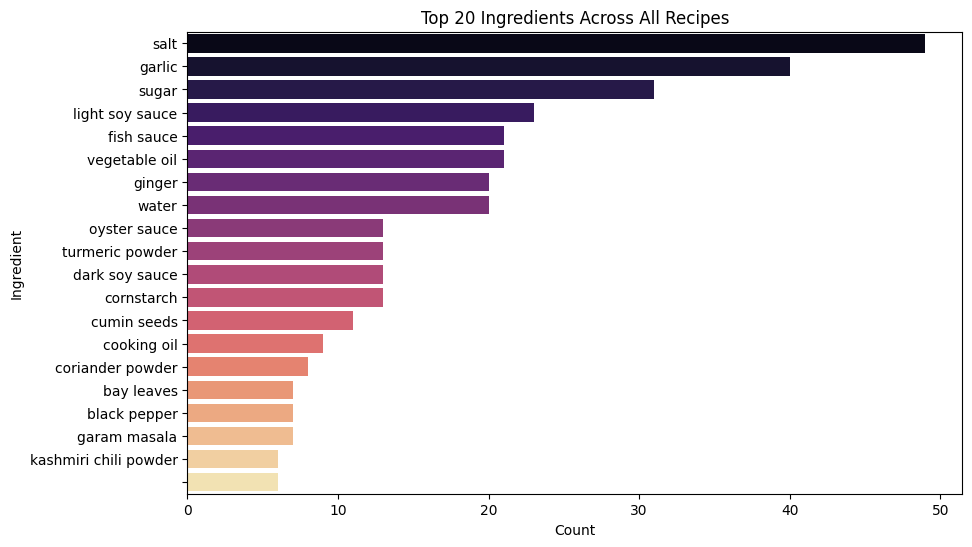

/tmp/ipython-input-2938171912.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20.values, y=top20.index, palette="magma")


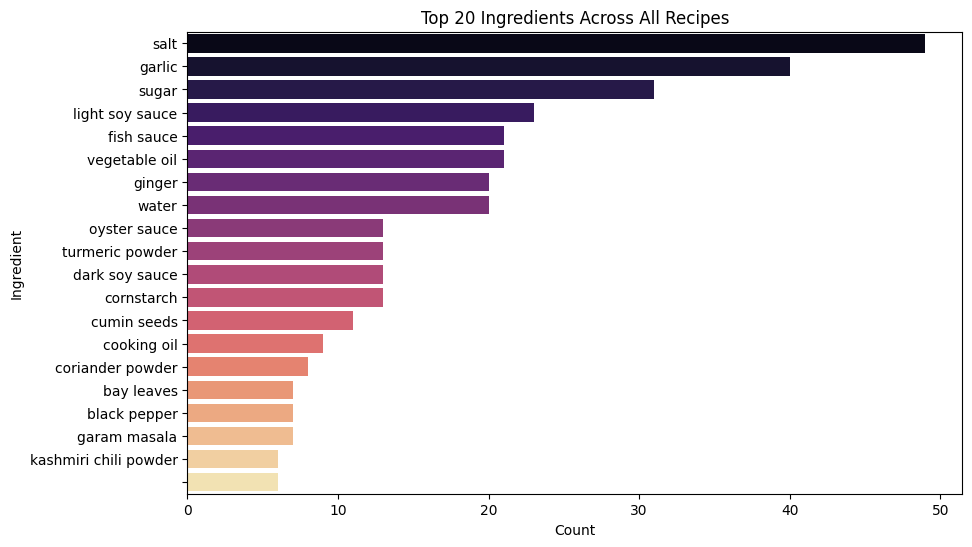

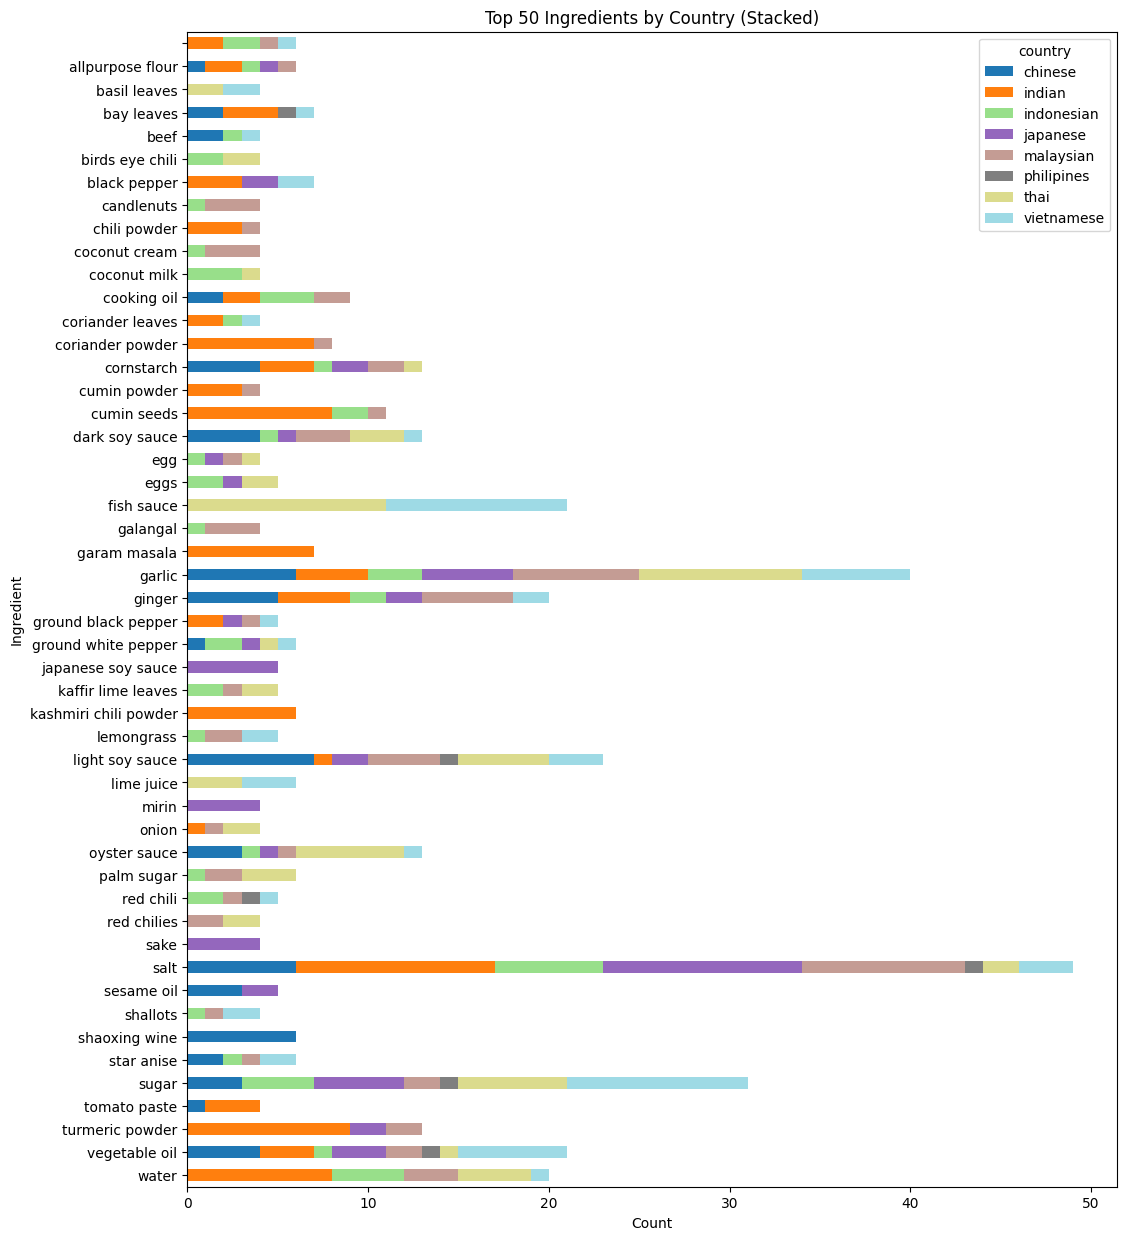

In [13]:
import re

def simplify_ingredient(ing):
    if pd.isna(ing):
        return None
    ing = ing.lower()
    ing = re.sub(r"\([^)]*\)", "", ing)  # remove ( ... )
    ing = re.sub(r"\d+[\d\s\/\.\-]*", "", ing)  # remove numbers
    ing = re.sub(r"\b(?:tsp|tbsp|cups?|cup|g|kg|ml|l|oz|pounds?|pound|cloves?|slices?|pieces?)\b", "", ing)
    ing = re.sub(r"\b(of|chopped|sliced|minced|diced|fresh|large|small|medium)\b", "", ing)
    ing = re.sub(r"[^a-zA-Z\s]", "", ing)  # keep only letters/spaces
    ing = ing.strip()
    return ing

# Apply cleaning
df["ingredient_simple"] = df["ingredient"].apply(simplify_ingredient)

import matplotlib.pyplot as plt
import seaborn as sns

top20 = df["ingredient_simple"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top20.values, y=top20.index, palette="magma")
plt.title("Top 20 Ingredients Across All Recipes")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

top20 = df["ingredient_simple"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top20.values, y=top20.index, palette="magma")
plt.title("Top 20 Ingredients Across All Recipes")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

# Count top 50 ingredients overall
top50 = df["ingredient_simple"].value_counts().head(50).index
df_top50 = df[df["ingredient_simple"].isin(top50)]

# Group by country + ingredient
counts = df_top50.groupby(["ingredient_simple","country"]).size().unstack(fill_value=0)

# Plot stacked bar
counts.plot(kind="barh", stacked=True, figsize=(12,15), colormap="tab20")
plt.title("Top 50 Ingredients by Country (Stacked)")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.gca().invert_yaxis()
plt.show()




/tmp/ipython-input-427752219.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df.drop_duplicates("recipe_title"),


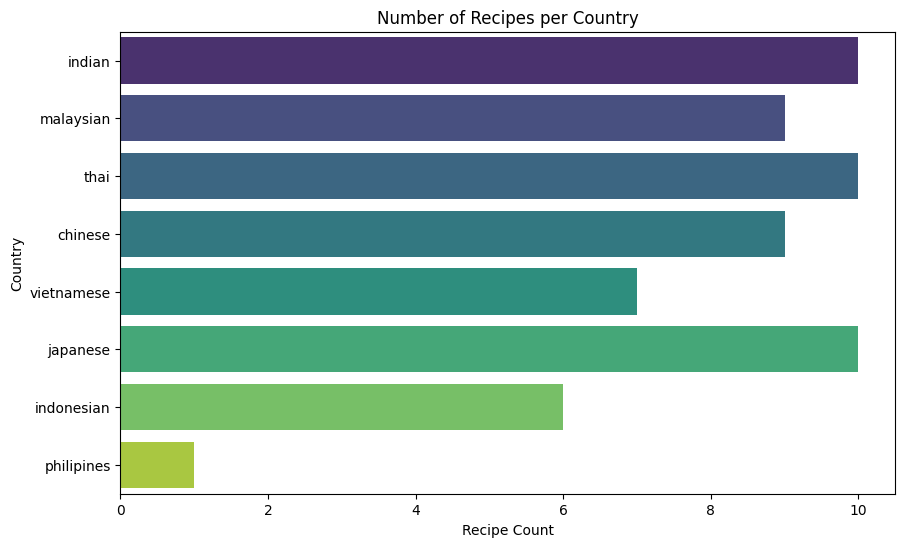

/tmp/ipython-input-427752219.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ing.values, y=top_ing.index, palette="magma")


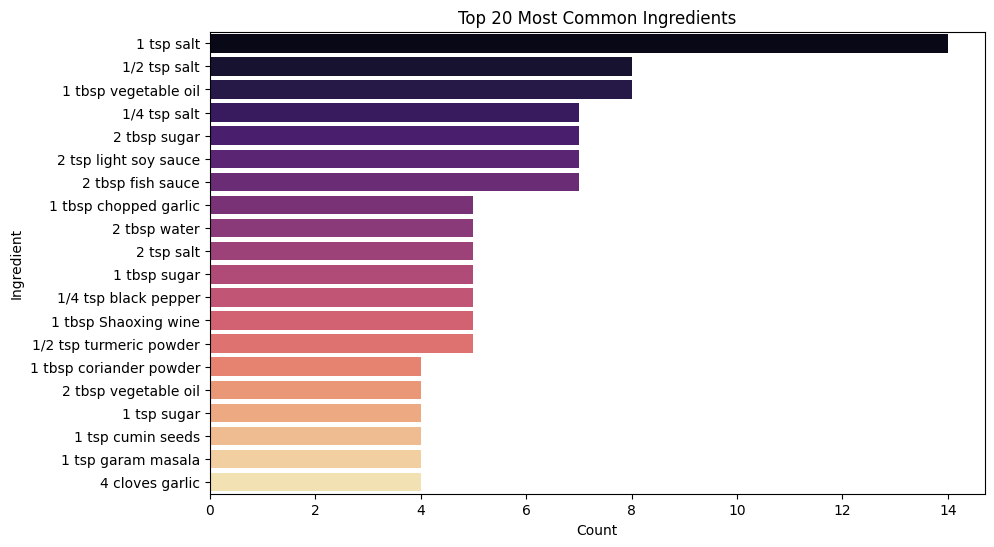

/tmp/ipython-input-427752219.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_ing_per_country.values, y=unique_ing_per_country.index, palette="coolwarm")


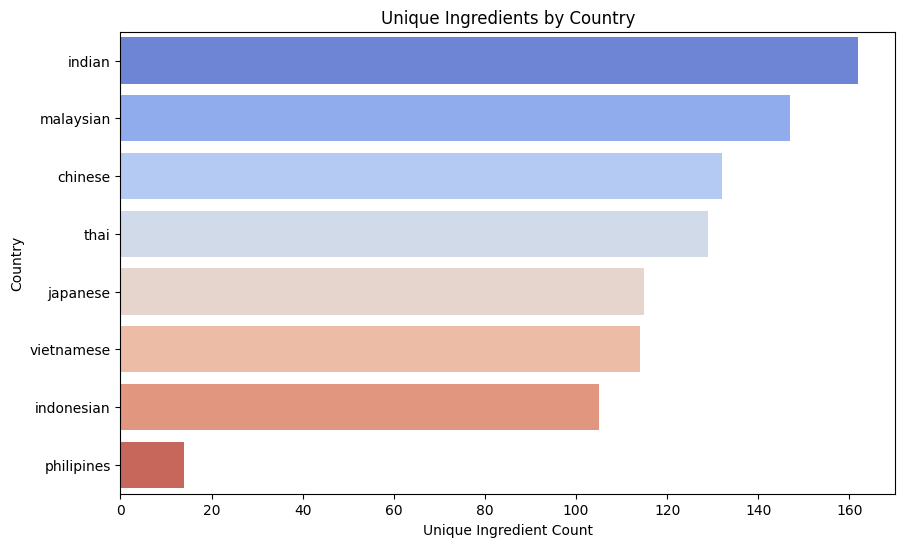

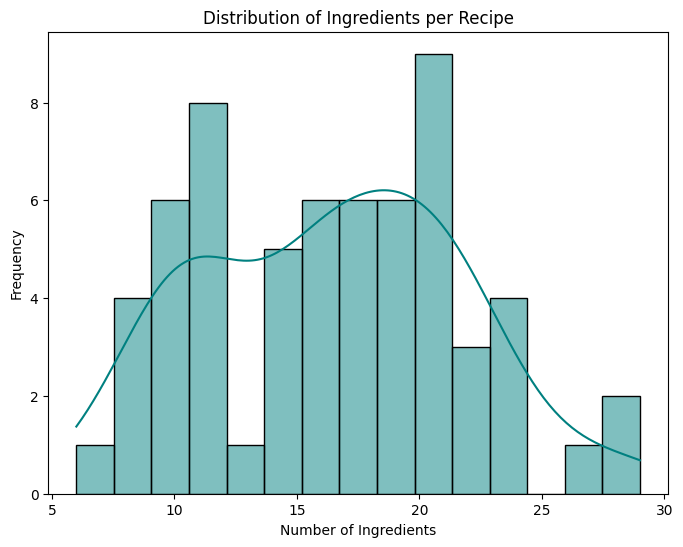

/tmp/ipython-input-427752219.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recipe_lengths_by_country, x="country", y="ingredient", palette="Set3")


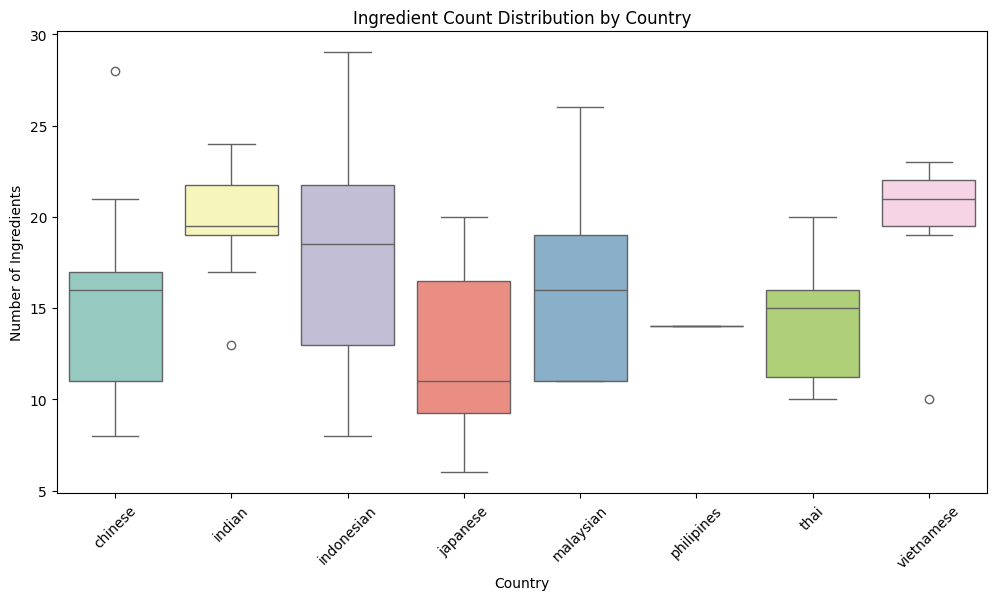

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Recipes per Country
# -----------------------------
plt.figure(figsize=(10,6))
sns.countplot(data=df.drop_duplicates("recipe_title"),
              y="country", order=df['country'].value_counts().index, palette="viridis")
plt.title("Number of Recipes per Country")
plt.xlabel("Recipe Count")
plt.ylabel("Country")
plt.show()

# -----------------------------
# 2. Top 20 Most Common Ingredients
# -----------------------------
top_ing = df['ingredient'].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ing.values, y=top_ing.index, palette="magma")
plt.title("Top 20 Most Common Ingredients")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

# -----------------------------
# 3. Ingredient Diversity by Country
# -----------------------------
unique_ing_per_country = (df.groupby("country")['ingredient']
                          .nunique()
                          .sort_values(ascending=False))

plt.figure(figsize=(10,6))
sns.barplot(x=unique_ing_per_country.values, y=unique_ing_per_country.index, palette="coolwarm")
plt.title("Unique Ingredients by Country")
plt.xlabel("Unique Ingredient Count")
plt.ylabel("Country")
plt.show()

# -----------------------------
# 4. Recipe Length Distribution
# -----------------------------
recipe_lengths = df.groupby("recipe_title")['ingredient'].count()

plt.figure(figsize=(8,6))
sns.histplot(recipe_lengths, bins=15, kde=True, color="teal")
plt.title("Distribution of Ingredients per Recipe")
plt.xlabel("Number of Ingredients")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# 5. Boxplot of Ingredient Counts by Country
# -----------------------------
recipe_lengths_by_country = (df.groupby(["country","recipe_title"])['ingredient']
                             .count()
                             .reset_index())

plt.figure(figsize=(12,6))
sns.boxplot(data=recipe_lengths_by_country, x="country", y="ingredient", palette="Set3")
plt.title("Ingredient Count Distribution by Country")
plt.ylabel("Number of Ingredients")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()


In [7]:
import pandas as pd

df = pd.read_csv("asian_recipes_by_country.csv")
print(df.columns)
df.head()


Index(['country', 'recipe_title', 'recipe_url', 'ingredient', 'instructions'], dtype='object')


,country,recipe_title,recipe_url,ingredient,instructions
0,chinese,Beef and mushrooms stir-fry Chinese style,https://tasteasianfood.com/beef-and-mushrooms/,300g beef (flank steak preferred),"[{'@type': 'HowToStep', 'text': 'Cut the flank..."
1,chinese,Beef and mushrooms stir-fry Chinese style,https://tasteasianfood.com/beef-and-mushrooms/,2 tbsp of vegetable oil,"[{'@type': 'HowToStep', 'text': 'Cut the flank..."
2,chinese,Beef and mushrooms stir-fry Chinese style,https://tasteasianfood.com/beef-and-mushrooms/,1 tbsp of chopped garlic,"[{'@type': 'HowToStep', 'text': 'Cut the flank..."
3,chinese,Beef and mushrooms stir-fry Chinese style,https://tasteasianfood.com/beef-and-mushrooms/,100g king oyster mushroom,"[{'@type': 'HowToStep', 'text': 'Cut the flank..."
4,chinese,Beef and mushrooms stir-fry Chinese style,https://tasteasianfood.com/beef-and-mushrooms/,100g button mushrooms,"[{'@type': 'HowToStep', 'text': 'Cut the flank..."
